# LSTM Prediction Model w/ Mobility Reports

## Set-Up and Data Upload

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/My Drive/Colab Notebooks/Models/data

/content/drive/My Drive/Colab Notebooks/Models/data


In [3]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
global_mobility = pd.read_csv("Global_Mobility_Report.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
os.chdir("COVID-19-master/csse_covid_19_data/csse_covid_19_time_series")

In [6]:
confirmed_cases = pd.read_csv("time_series_covid19_confirmed_US.csv")

## Cleaning 

### Mobility

In [7]:
us_mobility = global_mobility.loc[ (global_mobility.country_region_code=='US') ]
us_mobility.reset_index(drop=True, inplace=True)
us_mobility.head(3)

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,NaN,NaN,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,US,United States,NaN,NaN,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,US,United States,NaN,NaN,NaN,NaN,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0


In [8]:
us_mobility.shape

(414461, 13)

### Cases

In [9]:
confirmed_cases.shape

(3340, 194)

In [10]:
confirmed_cases.loc[ (confirmed_cases.Province_State=='American Samoa'), 'Admin2' ] = 'American Samoa'
confirmed_cases.loc[ (confirmed_cases.Province_State=='Guam'), 'Admin2' ] = 'Guam'
confirmed_cases.loc[ (confirmed_cases.Province_State=='Northern Mariana Islands'), 'Admin2' ] = 'Northern Mariana Islands'
confirmed_cases.loc[ (confirmed_cases.Province_State=='Virgin Islands'), 'Admin2' ] = 'Virgin Islands'
confirmed_cases.loc[ (confirmed_cases.Province_State=='Diamond Princess'), 'Admin2' ] = 'Diamond Princess'
confirmed_cases.loc[ (confirmed_cases.Province_State=='Grand Princess'), 'Admin2' ] = 'Grand Princess'

In [11]:
confirmed_cases.loc[ (confirmed_cases.Admin2=='Dukes and Nantucket'), 'FIPS' ] = 25007
confirmed_cases.loc[ (confirmed_cases.Admin2=='Kansas City'), 'FIPS' ] = 29095

In [12]:
confirmed_cases.dropna(inplace=True)

In [13]:
confirmed_cases.isnull().sum().sum()

0

In [14]:
cases_groups = confirmed_cases.groupby(['Province_State'])

## Model Without Mobility

In [15]:
## pass in a pandas group dataframe
def get_state_df(base_df, state):
  temp = base_df.get_group(state)
  return temp

In [16]:
def get_county_df(base_df, county):
  temp = base_df.loc[(base_df.Admin2==county)]
  return temp

In [30]:
state = 'New Jersey'
county = 'Essex'

In [18]:
nj_cases = get_state_df(cases_groups, state)
cases = get_county_df(nj_cases, county)
cases

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20
1862,84034013,US,USA,840,34013.0,Essex,New Jersey,US,40.786813,-74.24658,"Essex, New Jersey, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18336,18364,18375,18388,18421,18499,18533,18531,18551,18578,18592,18617,18637,18666,18696,18716,18731,18758,18771,18804,18842,18859,18887,18895,18918,18920,18928,18954,18988,19008,19039,19058,19100,19119,19111,19105,19105,19121,19153,19173


In [17]:
## only include date and number of cases
cases = cases.iloc[:, 11:]
cases

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20
1862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18336,18364,18375,18388,18421,18499,18533,18531,18551,18578,18592,18617,18637,18666,18696,18716,18731,18758,18771,18804,18842,18859,18887,18895,18918,18920,18928,18954,18988,19008,19039,19058,19100,19119,19111,19105,19105,19121,19153,19173


In [18]:
cases = cases.T

In [19]:
cases.rename(columns={1862: 'confirmed'}, inplace=True)

In [20]:
cases.index = pd.to_datetime(cases.index)
cases.head(3)

,confirmed
2020-01-22,0
2020-01-23,0
2020-01-24,0


Text(0.5, 1.0, 'Cumulative daily cases')

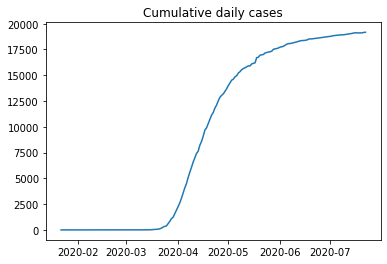

In [21]:
plt.plot(cases)
plt.title("Cumulative daily cases")

In [22]:
#df = cases.diff()

In [30]:
#df = df.fillna(cases.iloc[0, :].values[0]).astype(np.int64)

In [32]:
## Undo cumulative cases
cases = cases.diff().fillna(cases.iloc[0, :].values[0]).astype(np.int64)

Text(0.5, 1.0, 'Daily cases')

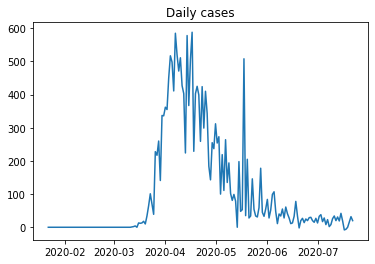

In [33]:
plt.plot(cases)
plt.title("Daily cases")

#### Preprocessing

In [34]:
cases.shape

(183, 1)

In [36]:
# 80/20 split
test_data_size = 36

train_data = cases[:-test_data_size]
test_data = cases[-test_data_size:]

train_data.shape

(147, 1)

In [43]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data)

In [44]:
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [47]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [48]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [50]:
print("X_train shape:{} \ny_train shape:{} \nX_test shape:{} \ny_test shape: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train shape:torch.Size([141, 5, 1]) 
y_train shape:torch.Size([141, 1]) 
X_test shape:torch.Size([30, 5, 1]) 
y_test shape: torch.Size([30, 1])


In [51]:
class LSTMPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(LSTMPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [52]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):
  loss_fn = torch.nn.MSELoss(reduction='sum')
  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(), y_train)
    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()
      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')
    train_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
  return model.eval(), train_hist, test_hist

In [54]:
model = LSTMPredictor(n_features=1, n_hidden=512, seq_len=seq_length, n_layers=2)

In [55]:
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 20.74845314025879 test loss: 0.13972829282283783
Epoch 10 train loss: 11.651948928833008 test loss: 1.071726679801941
Epoch 20 train loss: 11.592264175415039 test loss: 0.9441437721252441
Epoch 30 train loss: 11.033352851867676 test loss: 1.4848167896270752
Epoch 40 train loss: 11.89135456085205 test loss: 0.6503816246986389
Epoch 50 train loss: 11.745765686035156 test loss: 1.90584135055542


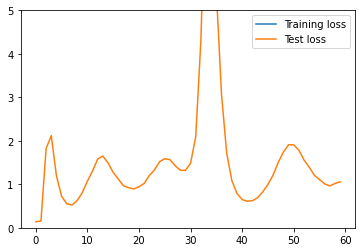

In [56]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend()

In [57]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [58]:
true_cases = scaler.inverse_transform(np.expand_dims(y_test.flatten().numpy(), axis=0)).flatten()
predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()

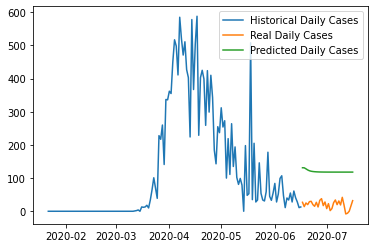

In [60]:
plt.plot(cases.index[:len(train_data)], scaler.inverse_transform(train_data).flatten(), label='Historical Daily Cases')
plt.plot(cases.index[len(train_data):len(train_data) + len(true_cases)], true_cases, label='Real Daily Cases')
plt.plot(cases.index[len(train_data):len(train_data) + len(true_cases)], predicted_cases, label='Predicted Daily Cases')
plt.legend()

## Model With Mobility

In [17]:
mobility_groups = us_mobility.groupby("sub_region_1")

In [18]:
mob = mobility_groups.get_group("New Jersey")
mob.shape

(3432, 13)

In [19]:
mob.isna().sum().sum()

4564

In [20]:
mob.reset_index(drop=True, inplace=True)

In [21]:
imob = mob.loc[ (mob.sub_region_2=='Essex County') ]
imob.head(3)

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
1092,US,United States,New Jersey,Essex County,NaN,34013.0,2020-02-15,3.0,-4.0,-7.0,-2.0,-1.0,0.0
1093,US,United States,New Jersey,Essex County,NaN,34013.0,2020-02-16,3.0,-6.0,9.0,-2.0,0.0,0.0
1094,US,United States,New Jersey,Essex County,NaN,34013.0,2020-02-17,6.0,-2.0,52.0,-17.0,-36.0,9.0


In [22]:
imob.reset_index(drop=True, inplace=True)

In [23]:
imob.date = pd.to_datetime(imob.date)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [24]:
imob.set_index('date', inplace=True, drop=True)

In [25]:
imob = imob.iloc[:, 6:]

In [26]:
imob.isna().sum()

retail_and_recreation_percent_change_from_baseline    0
grocery_and_pharmacy_percent_change_from_baseline     0
parks_percent_change_from_baseline                    1
transit_stations_percent_change_from_baseline         0
workplaces_percent_change_from_baseline               0
residential_percent_change_from_baseline              0
dtype: int64

In [27]:
imob.parks_percent_change_from_baseline.fillna(0.0, inplace=True)

In [28]:
imob.head()

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,
2020-02-15,3.0,-4.0,-7.0,-2.0,-1.0,0.0
2020-02-16,3.0,-6.0,9.0,-2.0,0.0,0.0
2020-02-17,6.0,-2.0,52.0,-17.0,-36.0,9.0
2020-02-18,0.0,0.0,1.0,2.0,-1.0,1.0
2020-02-19,1.0,-1.0,9.0,3.0,-1.0,0.0


In [29]:
state = 'New Jersey'
county = 'Essex'
nj_cases = get_state_df(cases_groups, state)
ecases = get_county_df(nj_cases, county)
ecases

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20
1862,84034013,US,USA,840,34013.0,Essex,New Jersey,US,40.786813,-74.24658,"Essex, New Jersey, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18336,18364,18375,18388,18421,18499,18533,18531,18551,18578,18592,18617,18637,18666,18696,18716,18731,18758,18771,18804,18842,18859,18887,18895,18918,18920,18928,18954,18988,19008,19039,19058,19100,19119,19111,19105,19105,19121,19153,19173


In [30]:
ecases = ecases.iloc[:, 11:]
ecases = ecases.T
ecases.rename(columns={1862: 'confirmed'}, inplace=True)
ecases.index = pd.to_datetime(ecases.index)
ecases = ecases.diff().fillna(ecases.iloc[0, :].values[0]).astype(np.int64)
ecases.head(3)

,confirmed
2020-01-22,0
2020-01-23,0
2020-01-24,0


### Joining the datasets

In [31]:
merged = pd.merge(ecases, imob, how='left', left_index=True, right_index=True)

In [51]:
#merged.residential_percent_change_from_baseline.fillna(0.0, inplace=True)
#merged.grocery_and_pharmacy_percent_change_from_baseline.fillna(0.0, inplace=True)
#merged.parks_percent_change_from_baseline.fillna(0.0, inplace=True)
#merged.transit_stations_percent_change_from_baseline.fillna(0.0, inplace=True)
#merged.workplaces_percent_change_from_baseline.fillna(0.0, inplace=True)
#merged.retail_and_recreation_percent_change_from_baseline.fillna(0.0, inplace=True)

In [ ]:
## change these to values from 2020-07-19 --> '2020-07-20', '2020-07-21', '2020-07-22'

In [32]:
merged.head()

,confirmed,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
2020-01-22,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,0,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
merged.dropna(inplace=True)

In [34]:
merged.columns

Index(['confirmed', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

### Build w/ Keras

In [35]:
from matplotlib import pyplot
import math

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


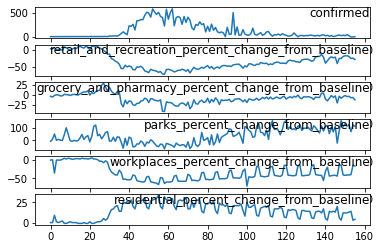

In [37]:
values = merged.values
groups = [0, 1, 2, 3, 5, 6]

i = 1

pyplot.figure()

for group in groups:
  pyplot.subplot(len(groups), 1, i)
  pyplot.plot(values[:, group])
  pyplot.title(merged.columns[group], y=0.5, loc='right')
  i += 1

pyplot.show()

In [38]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()

  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)

  return agg

In [39]:
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)

In [40]:
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[1, 2, 3, 4, 5, 6]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...   var5(t)   var6(t)   var7(t)
1   0.013423   0.904762   0.541667  ...  0.941860  0.934211  0.028571
2   0.013423   0.904762   0.513889  ...  0.767442  0.460526  0.285714
3   0.013423   0.940476   0.569444  ...  0.988372  0.921053  0.057143
4   0.013423   0.869048   0.597222  ...  1.000000  0.921053  0.028571
5   0.013423   0.880952   0.583333  ...  0.965116  0.921053  0.057143

[5 rows x 14 columns]


In [41]:
reframed.shape

(155, 14)

In [43]:
# 80-20 split
values = reframed.values
n_train_hours = 124
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(124, 1, 7) (124,) (31, 1, 7) (31,)


In [46]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 124 samples, validate on 31 samples
Epoch 1/50
 - 0s - loss: 0.4808 - val_loss: 0.2647
Epoch 2/50
 - 0s - loss: 0.4727 - val_loss: 0.2545
Epoch 3/50
 - 0s - loss: 0.4650 - val_loss: 0.2437
Epoch 4/50
 - 0s - loss: 0.4569 - val_loss: 0.2335
Epoch 5/50
 - 0s - loss: 0.4487 - val_loss: 0.2238
Epoch 6/50
 - 0s - loss: 0.4407 - val_loss: 0.2150
Epoch 7/50
 - 0s - loss: 0.4328 - val_loss: 0.2070
Epoch 8/50
 - 0s - loss: 0.4250 - val_loss: 0.1994
Epoch 9/50
 - 0s - loss: 0.4172 - val_loss: 0.1921
Epoch 10/50
 - 0s - loss: 0.4093 - val_loss: 0.1861
Epoch 11/50
 - 0s - loss: 0.4015 - val_loss: 0.1817
Epoch 12/50
 - 0s - loss: 0.3937 - val_loss: 0.1776
Epoch 13/50
 - 0s - loss: 0.3861 - val_loss: 0.1736
Epoch 14/50
 - 0s - loss: 0.3786 - val_loss: 0.1695
Epoch 15/50
 - 0s - loss: 0.3711 - val_loss: 0.1655
Epoch 16/50
 - 0s - loss: 0.3639 - val_loss: 0.1615
Epoch 17/50
 - 0s - loss: 0.3568 - val_loss: 0.1575
Epoch 18/50
 - 0s - loss: 0.3498 - val_loss: 0.1536
Epoch 19/50
 - 0s - loss: 0.

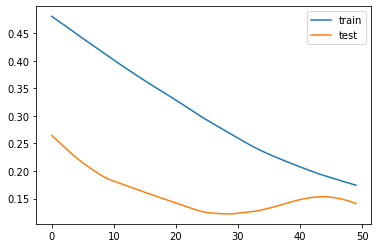

In [47]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [48]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [49]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [50]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [54]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 112.142


### Build w/ Tensorflow

In [43]:
features_considered = ['retail_and_recreation_percent_change_from_baseline',
                       'grocery_and_pharmacy_percent_change_from_baseline',
                       'parks_percent_change_from_baseline',
                       'transit_stations_percent_change_from_baseline',
                       'workplaces_percent_change_from_baseline',
                       'residential_percent_change_from_baseline']

In [ ]:
features = merged[features_considered]
features.index = merged.index
features.head()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4114d8e198>,
      dtype=object)

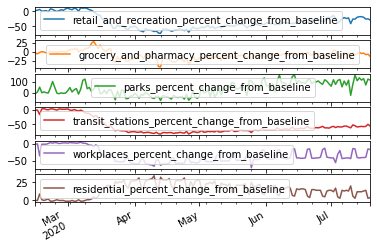

In [45]:
features.plot(subplots=True)

In [46]:
TRAIN_SPLIT = 124

In [47]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [48]:
dataset = (dataset-data_mean)/data_std

In [50]:
dataset.shape

(156, 6)

In [49]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [52]:
past_history = 0
future_target = 32
STEP = 1

In [53]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)